# SymmetricTree Test

Demonstrates performance differences between SymmetricTree and Python's dictionary object for tracking game state in a single-threaded environment. Note that:

1. SymmetricTree supports multi-threaded environments, allowing multi-core training.
2. SymmetricTree supports direct disk access, allowing game state trees larger than available memory.
3. For very large game state trees, SymmetricTree performs on-par with dictionaries even in single-threaded.

Thus, even though a dictionary is a better choice for small game state trees on single-threaded implementations, SymmetricTree has significant advantages when handling large, complex games. Games like Texas holdem' require  multi-threaded training, very deep and complex game state trees, and game state trees that exceed memory limits.

# Imports

In [1]:
import random
import time
from SymmetricTree import SymmetricTree

# Configure a Simple Static Symmetric Tree

In [2]:
# a simple symmetric tree shape with 10 choices at each level and 3 values tracked at the leaf
symmtree_shape = [

    # lets say the leaf of our tree has 10 possible choices
    (10 , 0 , 1),

    # the next level down also has 10 possible choices
    (10, 0, 10 * 10),

    # the next level down also has 10 possible choices
    (10, 0, 10 * 10 * 10),

    # and at the bottom of our tree with have some float value to track
    # for each of those paths, lets suppose they are 3 (regrets, strategy, and statistics)
    (3, 1, 10 * 10 * 10 * 10)

]

# create a new symmetric tree with that shape
print("Creating Symmetric Tree")
symm_tree = SymmetricTree(shape=symmtree_shape,namespace="SymMTreeTest")

Creating Symmetric Tree


# Compare Symmetric Tree and Dictionary on Simple Operations

For simple operations like this, the dictionary far outperforms the symmetric tree

In [3]:
# lets get a sample path
path = [
    (1, 0),
    (1, 1),
    (1, 2),
    (1, 3)
]

# test at 100k iterations
iterations = 10 ** 5
print(f"Executing {iterations} gets and sets...")

# get a start time
starttime = int(time.time())

for n in range(iterations):

    # write a value
    symm_tree.set( path , 69.2)

    # read a value
    x = symm_tree.get(path)

# get some stats on the run
endtime = int(time.time())
elapsedtime = endtime-starttime
speed = iterations / elapsedtime

# write some stats
print(f"Completed {iterations} in {elapsedtime} seconds at {speed:.1f} per second")


#perform the same test with a dictionary
control_dict = {1:{1:{1:{1:0.0}}}}

# get a start time
starttime = int(time.time())
for n in range(iterations):

    # write a value
    control_dict[1][1][1][1] = 69.2

    # read a value
    x = control_dict[1][1][1][1]

# get some stats on the run
endtime = int(time.time())
elapsedtime = endtime-starttime + 0.01
speed = iterations / elapsedtime
print(f"Completed {iterations} in {elapsedtime} seconds at {speed:.1f} per second")

Executing 100000 gets and sets...
Completed 100000 in 2 seconds at 50000.0 per second
Completed 100000 in 0.01 seconds at 10000000.0 per second


# Compare Symmetric Tree and Dictionary on Complex Paths

Now that the dictionary must allocate paths as its going, its performance has changed significantly.

The symmetric tree performance had no change because the allocation happens before the loop begins

However, these are still static paths so the dictionary has an edge over the symmetric tree

In [ ]:
# test at 100k iterations
iterations = 10 ** 3
print(f"Executing {iterations} gets and sets...")

# get a start time
starttime = int(time.time())

for n in range(iterations):
    
    # get a random path
    path = [
        (random.randint(1,9), 0),
        (random.randint(1,9), 1),
        (random.randint(1,9), 2),
        (random.randint(1,3), 3)
    ]

    # get a random value to set
    value = random.random() * 100


    # write a value
    symm_tree.set( path , value)

    # read a value
    x = symm_tree.get(path)

# get some stats on the run
endtime = int(time.time())
elapsedtime = endtime-starttime + 0.0001
speed = iterations / elapsedtime

# write some stats
print(f"Completed {iterations} in {elapsedtime} seconds at {speed:.1f} per second")


#perform the same test with a dictionary
control_dict = {1:{1:{1:{1:0.0}}}}

# get a start time
starttime = int(time.time())
for n in range(iterations):
    
    # lets get a sample path
    path = [
        (random.randint(1,9), 0),
        (random.randint(1,9), 1),
        (random.randint(1,9), 2),
        (random.randint(1,3), 3)
    ]
    
    # get a random value to set
    value = random.random() * 100
    
    # create path 1 if missing
    if not path[0] in control_dict:
        control_dict[path[0]] = {}
        
    # get path 1
    p1 = control_dict[path[0]]
    
    # create path 2 if missing
    if not path[1] in p1:
        p1[path[1]] = {}
    
    # get path 2
    p2 = p1[path[1]]

    # create path 3 if missing
    if not path[2] in p2:
        p2[path[2]] = {}
        
    # get path 3
    p3 = p2[path[2]]
    
    # set value on path 4
    p3[path[3]] = value
    
    # read a value
    x = control_dict[path[0]][path[1]][path[2]][path[3]]

# get some stats on the run
endtime = int(time.time())
elapsedtime = endtime-starttime + 0.0001
speed = iterations / elapsedtime
print(f"Completed {iterations} in {elapsedtime} seconds at {speed:.1f} per second")

# Compare dynamic paths

In this example, the length of the path is not know, we can no longer rely on simple tricks with the dictionary. This is one of the key features of the symmetric tree. It can handle variable depth trees easily.

In [2]:
# lets setup a structure to track our timings so we visually compare them

timings = {
    "Depths":[5,10,15,20,25,30,35,40,45,50,55,60],
    "Iterations":[10 ** 5],
    "Axis":[],
    "SymmTree": [],
    "Dictionary": []
}

In [3]:
# function that generates a random dynamic path, we can call for both implementations
def gen_random_path(depth):
    # the first part of the path is static
    path = [
        (random.randint(0,2), 0),
        (random.randint(0,2), 1)
    ]
    
    # now, lets generate a random depth for the 3rd part of the path
    for d in range(depth):                
        path += [(random.randint(0,2),2),(0,3)]
    path += [(random.randint(0, 2), 2), (1, 3), (random.randint(0, 2), 4)]
    
    # return that path to caller
    return path


# Setup Symmetric Tree for Random Path Lengths

In [4]:

# a simple symmetric tree shape with 10 choices at each level and 3 values tracked at the leaf
dsymmtree_shape = [

    # lets say the leaf of our tree has 3 possible choices
    (3 , 0 , 1),

    # the next level down also has 3 possible choices
    (3, 0, 3),

    # the next level down also has 3 possible choices
    # but this is now a dynamic path so we may need much more storage
    (3, 0, 3 * 3 * 3 * 10 * 10 * 10 * 10 * 10 * 10 * 10),
    
    # this portion of the path allows us to define leaf vs non-leaf paths
    (2, 0, 3 * 3 * 3 * 10 * 10 * 10 * 10 * 10 * 10 * 10 * 3),

    # and at the bottom of our tree with have some float value to track
    # for each of those paths, lets suppose they are 3 (regrets, strategy, and statistics)
    (3, 1, 3 * 3 * 3 * 10 * 10 * 10 * 10 * 10 * 10 * 10 * 3 * 2)

]

# create a new symmetric tree with that shape
print("Creating Dynamic Path Symmetric Tree")
dsymm_tree = SymmetricTree(shape=dsymmtree_shape)

# we would use below to execute in a shared memory namespace but don't need that for our testing
#dsymm_tree = SymmetricTree(shape=dsymmtree_shape,namespace="SymMTreeTest2")

Creating Dynamic Path Symmetric Tree


# Test Symmetric Tree with Random Path Lengths

In [5]:
# for all iteration counts in our timing dictionary
for iterations in timings["Iterations"]:
    
    # prior depth starts at 1
    priordepth = 1

    # for all depth counts in our timing dictionary
    for depth in timings["Depths"]:
        
        # log that we are executing thi
        print(f"Executing {iterations} gets and sets at depths between {priordepth} and {depth}")

        # get a start time
        starttime = int(time.time())

        for n in range(iterations):

            # get a random path 
            d = random.randint(priordepth,depth)
            path = gen_random_path(d)

            # get a random value to set
            value = random.random() * 100

            # write a value
            dsymm_tree.set( path , value)

            # check that the value was written


            # get a new random path 
            d = random.randint(priordepth,depth)
            path = gen_random_path(d)

            # read a value
            x = dsymm_tree.get(path)

        # get some stats on the run
        endtime = int(time.time())
        elapsedtime = endtime-starttime
        
        # do not allow divide by zero
        elapsedtime = 0.0001 if elapsedtime == 0 else elapsedtime
        
        # calculate speed
        speed = iterations / elapsedtime
        
        # save this time for charting below
        timings["Axis"].append(depth)
        timings["SymmTree"].append(speed)

        # write some stats
        print(f"Completed {iterations} at depth {priordepth}-{depth} in {elapsedtime} seconds at {speed:.1f} per second")

        # depth is now prior depth
        priordepth = depth


Executing 100000 gets and sets at depths between 1 and 5
Completed 100000 at depth 1-5 in 7 seconds at 14285.7 per second
Executing 100000 gets and sets at depths between 5 and 10
Completed 100000 at depth 5-10 in 11 seconds at 9090.9 per second
Executing 100000 gets and sets at depths between 10 and 15
Completed 100000 at depth 10-15 in 17 seconds at 5882.4 per second
Executing 100000 gets and sets at depths between 15 and 20
Completed 100000 at depth 15-20 in 24 seconds at 4166.7 per second
Executing 100000 gets and sets at depths between 20 and 25
Completed 100000 at depth 20-25 in 29 seconds at 3448.3 per second
Executing 100000 gets and sets at depths between 25 and 30
Completed 100000 at depth 25-30 in 36 seconds at 2777.8 per second
Executing 100000 gets and sets at depths between 30 and 35
Completed 100000 at depth 30-35 in 41 seconds at 2439.0 per second
Executing 100000 gets and sets at depths between 35 and 40
Completed 100000 at depth 35-40 in 47 seconds at 2127.7 per secon

# Helper Functions For Dictionary Implementation

In [6]:
# this function sets a value at a path
def set_dict_value_at_path(d,path):
    
    # step through the path 
    for p in path:
        
        # if we are not at the leaf path
        if p[1] != 4:
            
            # create the dictionary if it doesn't already exist
            if not p[0] in d:
                d[p[0]] = {}
                
            # this is the new dictionary
            d = d[p[0]]
            
        else:
            
            #for the leaf level, write the value
            d[p[0]] = value    

# this function gets a value at a path
def get_dict_value_at_path(d,path):
    
    # step through the path 
    for p in path:
        
        # if we are not at the leaf path
        if p[1] != 4:
            
            # create the dictionary if it doesn't already exist
            if not p[0] in d:
                d[p[0]] = {}
                
            # this is the new dictionary
            d = d[p[0]]
            
        else:
            
            # for the leaf level, get the value, defaulting to ZERO
            value = d.get(p[0],0)
            
    # return the value at the leaf of that path
    return value
    
    

# Test Dictionary With Random Path Lengths

In [7]:

#perform the same test with a dictionary
control_dict = {1:{1:{1:{1:0.0}}}}

# for all iteration counts in our timing dictionary
for iterations in timings["Iterations"]:
    
    # prior depth starts at 1
    priordepth = 1

    # for all depth counts in our timing dictionary
    for depth in timings["Depths"]:
        
        # log that we are executing thi
        print(f"Executing {iterations} gets and sets at depths between {priordepth} and {depth}")

        # get a start time
        starttime = int(time.time())

        for n in range(iterations):

            # get a random path 
            d = random.randint(priordepth,depth)
            path = gen_random_path(d)

            # get a random value to set
            value = random.random() * 100

            # set our value at that random path
            set_dict_value_at_path(control_dict, path)

            # check that the value was written

            # get a new random path 
            d = random.randint(priordepth,depth)
            path = gen_random_path(d)

            # read the value at that path from the dictionary
            x = get_dict_value_at_path(control_dict, path)
    
        # get some stats on the run
        endtime = int(time.time())
        elapsedtime = endtime-starttime
        
        # do not allow divide by zero
        elapsedtime = 0.0001 if elapsedtime == 0 else elapsedtime
        
        # calculate speed
        speed = iterations / elapsedtime
        
        # save this time for charting below
        # here we don't append to axis because that was built in the first one
        timings["Dictionary"].append(speed)

        # write some stats
        print(f"Completed {iterations} at depth {priordepth}-{depth} in {elapsedtime} seconds at {speed:.1f} per second")

        # depth is now prior depth
        priordepth = depth
        


Executing 100000 gets and sets at depths between 1 and 5
Completed 100000 at depth 1-5 in 1 seconds at 100000.0 per second
Executing 100000 gets and sets at depths between 5 and 10
Completed 100000 at depth 5-10 in 1 seconds at 100000.0 per second
Executing 100000 gets and sets at depths between 10 and 15
Completed 100000 at depth 10-15 in 3 seconds at 33333.3 per second
Executing 100000 gets and sets at depths between 15 and 20
Completed 100000 at depth 15-20 in 5 seconds at 20000.0 per second
Executing 100000 gets and sets at depths between 20 and 25
Completed 100000 at depth 20-25 in 6 seconds at 16666.7 per second
Executing 100000 gets and sets at depths between 25 and 30
Completed 100000 at depth 25-30 in 6 seconds at 16666.7 per second
Executing 100000 gets and sets at depths between 30 and 35
Completed 100000 at depth 30-35 in 14 seconds at 7142.9 per second
Executing 100000 gets and sets at depths between 35 and 40
Completed 100000 at depth 35-40 in 42 seconds at 2381.0 per sec

# Display Test Results

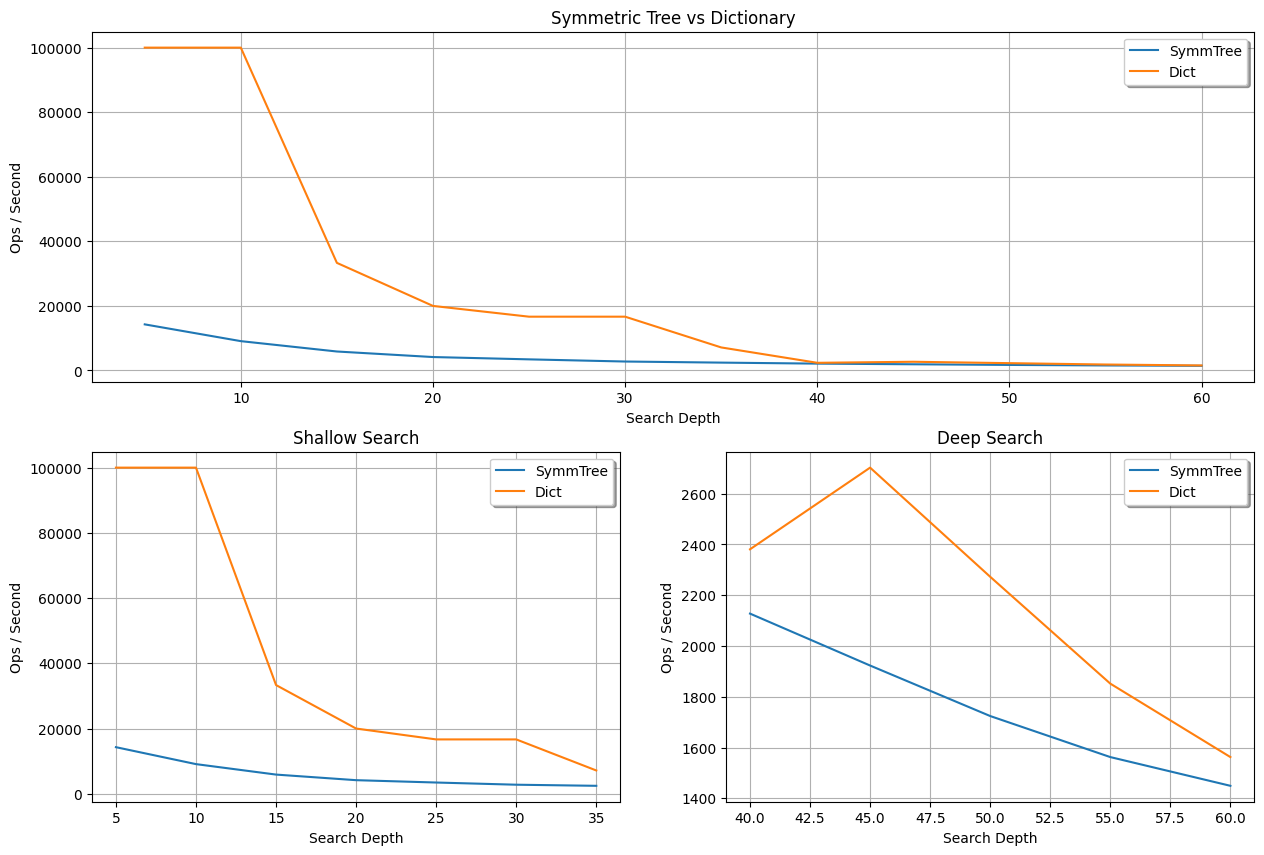

In [75]:
def simple_subplot(fig, coords, x, ys, legends, labels):
    # COORDS: per matplotlib a 3-item tuple where 1st is nrows, 2nd is ncols, and 3rd is grid index
    # grid index can be 1 number, or a tuple with span start/end
    
    ax = fig.add_subplot(coords[0],coords[1],coords[2])
    lines = []
    for y in ys:
        line, = ax.plot(x, y)
        lines.append(line)
    ax.legend(tuple(lines),legends,loc='upper right',shadow=True)
    ax.set(xlabel=labels[1], ylabel=labels[2],title=labels[0])
    ax.grid()
    return ax

    
    
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple

# Data for plotting
t = timings["Axis"]
t = [5,10,15,20,25,30,35,40,45,50,55,60]
s1 = [t  for t in timings["SymmTree"]]
s2 = [t  for t in timings["Dictionary"]]

fig = plt.figure(figsize=(15,10))
simple_subplot(fig,(2,2,(1,2)),t,(s1,s2),('SymmTree','Dict'),('Symmetric Tree vs Dictionary','Search Depth','Ops / Second'))
simple_subplot(fig,(2,2,3),t[:7],(s1[:7],s2[:7]),('SymmTree','Dict'),('Shallow Search','Search Depth','Ops / Second'))
simple_subplot(fig,(2,2,4),t[7:],(s1[7:],s2[7:]),('SymmTree','Dict'),('Deep Search','Search Depth','Ops / Second'))
plt.show()

# annotate dictionary
#for xy in zip(t, [int(s) for s in s2]):
#    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

# annotate symmetric tree
#for xy in zip(t, [int(s) for s in s1]):
#    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

#display results
#fig.savefig("test.png")

